![](/img/ti4cover.jpeg)

# Data and Twilight Imperium, Part 1: Introduction, Cleaning, and Graphing Game Completion
I've been quite impressed with how the Twilight Imperium community handles [their match data](https://lookerstudio.google.com/u/0/reporting/3b435bf2-2100-488c-a424-130f1d22ebb0/page/pE58B?params=%7B%22df333%22:%22include%25EE%2580%25801%25EE%2580%2580IN%25EE%2580%25805%22%7D). No one would blame them for not keeping track of the torrents of data generated by such a complex game, but not only have they risen to the task, but the analysts in the community have managed to wrangle and present it in a compelling way that can inform the play-by-play decisions of avid players.

Taking a bit of inspiration from them, I thought I might try my hand at taking the same data and recreating its presentation on my own to the best of my ability. Along the way, I hope to improve my facility with Jupyter Notebooks and Python's Pandas and Matplotlib libraries.

## What is Twilight Imperium
[Twilight Imperium](https://en.wikipedia.org/wiki/Twilight_Imperium) is an enormous board game of war, strategy, and diplomacy. Taking place in a colorful sci-fi setting, each player controls a unique faction and competes to be the first to reach ten (or sometimes fourteen) victory points. The game is famous for its complexity and length of play; the map of the galaxy is generated randomly, then players each choose one of twenty-five factions with completely unique abilities and play styles. A 'quick' game will only last four hours, but it's not unusual for games to last ten hours or more, especially offline.

![](/img/ti4_example.jpeg)

The game was first released in 1997 as a passion project of Christian T. Petersen, the founder and then-owner of Fantasy Flight Games (FFG). Although the game has always had a die-hard cult following since the very beginning, the game reached new heights of popularity with the release of its fourth edition (TI4) in August 2017, followed three years later with its first and so-far only expansion, *Prophecy of Kings*. A volunteer-created port of the game into [Tabletop Simulator](https://en.wikipedia.org/wiki/Tabletop_Simulator) (TTS) made it easier to host tournaments and pickup games, as well as to help potential new players try out TI4 without making a daunting $100+ investment. Because of this, it's no surprise that FFG themselves semi-officially condone the port, which they probably see as effective word-of-mouth advertising for a difficult product to sell. [Podcasts](https://spacecatspeaceturtles.com/) and [Youtube channels](https://www.youtube.com/@TIJunkies) have sprung up out of the TI4 community, and FFG has been slowly but steadily expanding the product line with [tie-in novels](https://www.fantasyflightgames.com/en/twilight-imperium-fiction/) and a [roll-and-write version of the game](https://www.fantasyflightgames.com/en/twilight-inscription/) (think Yahtzee, but much, much more complicated).

## The Data
As a consequence of online TTS games, fans have been able to collect tons and tons of data from each match. Data analysts among them have collated these data into a dashboard with useful and captivating visuals that update with every game played.

Here's a description of the data from the [dashboard](https://lookerstudio.google.com/u/0/reporting/3b435bf2-2100-488c-a424-130f1d22ebb0/page/pE58B?params=%7B%22df333%22:%22include%25EE%2580%25801%25EE%2580%2580IN%25EE%2580%25805%22%7D):

>A snapshot of the board state is saved at the start of every round (and at the end of the game when the roundplusfinal column = 'final'). In this table, each row represents one of these snapshots of one of the players. A 6 player game that goes for 5 rounds will have 36 rows total (one snapshot per round per player, plus another snapshot at the final end state of the game). The setupTimestamp field is used to differentiate between different matches.

I downloaded the data at exactly 3:31pm on July 5th, 2023. The resulting CSV file is 320.3 MB and contains over 286,290 rows and twenty-seven columns. The oldest data were added on February 28, 2021. Since one game can cover multiple rows and each game is uniquely identified with the setupTimestamp column, a .nunique() method shows that this dataset represents 9,082 games.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
df = pd.read_csv('TI4 Tabletop Simulator Stats Dashboard.csv')
print(df.info())
print(df.tail(10))
df.nunique()

/var/folders/8p/sbpv06dx3b576tlsdyc4cs9c0000gn/T/ipykernel_4032/2064672778.py:5: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('TI4 Tabletop Simulator Stats Dashboard.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286290 entries, 0 to 286289
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Date                         286290 non-null  object 
 1   setupTimestamp               286290 non-null  float64
 2   Timestamp                    286290 non-null  float64
 3   mapString                    65737 non-null   object 
 4   isHomebrewMatch              286290 non-null  bool   
 5   isPOK                        286290 non-null  bool   
 6   roundPlusFinal               286290 non-null  object 
 7   color                        286290 non-null  object 
 8   active                       286233 non-null  object 
 9   score                        286290 non-null  int64  
 10  custodiansPoints             286239 non-null  float64
 11  Winning Faction              286290 non-null  object 
 12  isPOK.1                      286290 non-null  bool   
 13 

Date                             9082
setupTimestamp                   9084
Timestamp                        9084
mapString                        1204
isHomebrewMatch                     2
isPOK                               2
roundPlusFinal                     13
color                              12
active                              3
score                              16
custodiansPoints                    8
Winning Faction                    94
isPOK.1                             2
Player Count                        7
factionName                       128
factionNameWinner                  94
objectives                     104076
Public_Objectives_I              9171
Public_Objectives_II             1718
leaders                            38
technologies                    44489
hexSummaryImageURLHyperlink     46272
strategyCards                      19
strategyCards2                     16
isSpeaker                           2
factionsInGame                  16992
gameDuration

## Cleaning
As one might expect from such copious amounts of data from such a complex game, there are more null values than I think most data analysts would be comfortable with. This might reflect an issue with how data is collected from TTS games or even player knowledge of how to properly send it. For now, though, the only column that we should be careful with is the `mapString` data, which describe board states at each round for every game.

As we can see, column 21 (`hexSummaryImageURLHyperlink`) has mixed data types. Normally, this would need to be corrected, but considering that this data stores a hyperlink to help display board states, it might be best to ignore it for now. Of more concern is that the date column holds strings instead of the `datetime` datatype. Let's fix that:

In [2]:
df['Date'].head


<bound method NDFrame.head of 0           Jul 1, 2023, 3:09:34 PM
1           Jul 1, 2023, 3:09:34 PM
2           Jul 1, 2023, 3:09:34 PM
3           Jul 1, 2023, 3:09:34 PM
4           Jul 1, 2023, 3:09:34 PM
                    ...            
286285    Feb 28, 2021, 12:11:30 AM
286286    Feb 28, 2021, 12:11:30 AM
286287    Feb 28, 2021, 12:11:30 AM
286288    Feb 28, 2021, 12:11:30 AM
286289    Feb 28, 2021, 12:11:30 AM
Name: Date, Length: 286290, dtype: object>

In [3]:
df['DateFixed'] = pd.to_datetime(df['Date'], format='%b %d, %Y, %I:%M:%S %p')
df['DateFixed'].head

<bound method NDFrame.head of 0        2023-07-01 15:09:34
1        2023-07-01 15:09:34
2        2023-07-01 15:09:34
3        2023-07-01 15:09:34
4        2023-07-01 15:09:34
                 ...        
286285   2021-02-28 00:11:30
286286   2021-02-28 00:11:30
286287   2021-02-28 00:11:30
286288   2021-02-28 00:11:30
286289   2021-02-28 00:11:30
Name: DateFixed, Length: 286290, dtype: datetime64[ns]>

In [4]:
print(df['DateFixed'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 286290 entries, 0 to 286289
Series name: DateFixed
Non-Null Count   Dtype         
--------------   -----         
286290 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.2 MB
None


# Analyzing and Visualizing the Data
Let's try to recreate one of the first charts on the [dashboard](https://lookerstudio.google.com/u/0/reporting/3b435bf2-2100-488c-a424-130f1d22ebb0/page/pE58B?params=%7B%22df333%22:%22include%25EE%2580%25801%25EE%2580%2580IN%25EE%2580%25805%22%7D): Match Completion Rates. The site describes the data thusly:

>This is the percentage of submitted matches that are considered complete. A game is considered incomplete if noone has reached the VP target (e.g. 10 or 14 VP), and can occur if players leave the match without updating the score tracker to reflect the final scores. Placing a command token on the final notch of the score tracker will trigger a stats update.

It's no surprise that a long game like Twilight Imperium would have less than a 70% completion rate. However, as mentioned in the description above, some of the low completion rates might be inaccurate simply because players don't know how to properly use the TTS mod to report data.

First, since each observation is represents one player per round, we need to aggregate each game by the unique `setupTimestamp` series. We'll need to add a Boolean series to determine whether or not someone reached the final score of 10 or 14. The simplest way to do this would be to use the `Winning Faction` series.


In [5]:
# Creating a new data frame from columns from the original dataframe.
completionRate = df[['DateFixed','Winning Faction','setupTimestamp']].copy()

# Adding a column with Boolean data types to indicate whether the game is complete or not.
completionRate['Complete'] = completionRate['Winning Faction'] != 'Incomplete Match'

# Aggregating the data by setupTimestamp
completionRate1 = completionRate.groupby('setupTimestamp', as_index=False).first()

print(completionRate1.info())
print(completionRate1.head())
print(completionRate1.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9084 entries, 0 to 9083
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   setupTimestamp   9084 non-null   float64       
 1   DateFixed        9084 non-null   datetime64[ns]
 2   Winning Faction  9084 non-null   object        
 3   Complete         9084 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(1)
memory usage: 221.9+ KB
None
   setupTimestamp           DateFixed    Winning Faction  Complete
0    1.614471e+09 2021-02-28 00:11:30  Emirates of Hacan      True
1    1.614476e+09 2021-02-28 01:31:56   Incomplete Match     False
2    1.614493e+09 2021-02-28 06:16:36   Incomplete Match     False
3    1.614499e+09 2021-02-28 07:50:19       Titans of Ul      True
4    1.614499e+09 2021-02-28 07:57:52   Incomplete Match     False
      setupTimestamp           DateFixed   Winning Faction  Complete
9079    1.688170e+

The data frame has been reduced to 9,084 rows, which matches the current number of games in the database. Seeing as there are no null values, I think this data is ready for analysis.

Let's go back to the original chart from the dashboard:

<img src="completionrate_screenshot.png" style="width: 500px;"/>

The chart's x-axis represents time, the left y-axis represents completed game count, and the right y-axis represents the completion rate itself. It also seems that the x-axis is delimited by month. Keeping that in mind, let's try to recreate that visualization with Pandas and Matplotlib:


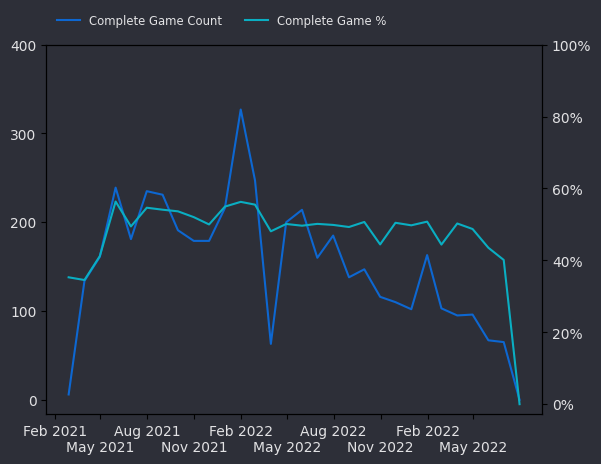

In [6]:
# Grouping the results by month.
grouper = pd.Grouper(key='DateFixed', freq='M')
CompleteCount = completionRate1.groupby(grouper)['Complete'].sum().reset_index()
CompleteRate = completionRate1.groupby(grouper)['Complete'].apply(lambda x: np.sum(x)/len(x))

# Setting up the axes, labels and colors.
fig, ax1 = plt.subplots(facecolor='#2d2f38')
ax1.plot(CompleteCount['DateFixed'], CompleteCount['Complete'], color='#0d67d1')
ax1.set_yticks([0,100,200,300,400])
ax1.set_yticklabels([0,100,200,300,400], color='#e2e2e4')
ax2 = ax1.twinx()
ax2.plot(CompleteCount['DateFixed'], CompleteRate, color='#0aaec2')
ax2.set_yticks([0.0,0.20,0.4,0.6,0.8,1.0])
ax2.set_yticklabels(['0%','20%','40%','60%','80%','100%'], color='#e2e2e4')
ax1.set_facecolor('#2d2f38')

ax1.set_xticks(['2021-02','2021-05','2021-08','2021-11','2022-02','2022-05','2022-08','2022-11','2023-02','2023-05'])
ax1.set_xticklabels(['Feb 2021','May 2021','Aug 2021','Nov 2021','Feb 2022','May 2022','Aug 2022','Nov 2022','Feb 2022','May 2022'], color='#e2e2e4')
for tick in ax1.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)

# Setting up the legend
legend1 = mlines.Line2D([], [], color='#0d67d1', label='Complete Game Count')
legend2 = mlines.Line2D([], [], color='#0aaec2', label='Complete Game %')
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', fontsize = 'small', facecolor = '#2d2f38', labelcolor = '#e2e2e4', edgecolor = '#2d2f38', ncols=2, handles=[legend1,legend2])
#plt.gca().legend(('Completion Rate %','Completion Game Count'))

# Show Plot
plt.show()

![](completion_graph.png)
# Conclusion

There's a few things missing from the chart to make it complete, notably the annotations for each point plotted. I'm satisfied for now, though. It was really neat digging into the documentation of Matplotlib to get everything working just right. I also think that this is a chart that can be used to make decisions or at least guide future inquiry. For example, I'd be interested to see if the declines in complete game percentage track with influxes of new players, who typically aren't aware of how to correctly report their data. I look forward to working with this dataset in the future and uncovering more insights into this intriguing game.